In [109]:
from typing import (
    List,
    Tuple,
    Dict,
    Optional,
)

import os
import sys
import csv

import altair as alt
import pandas as pd

EXPERIMENT_DIR = 'data/window_collation'

In [113]:
METRICS = {
    'al/valid/f1-measure-overall': 'Span F1',
    'al/valid/precision-measure-overall': 'Span Precision',
    'al/valid/recall-measure-overall': 'Span Recall',
    'al/valid/tag_f1': 'Token F1',
    'al/valid/tag_precision': 'Token Precision',
    'al/valid/tag_recall': 'Token Recall',
}

DataDef = List[
    Dict[str, object]
]

def parse_file(
    file_name: str,
    **kwargs,
) -> DataDef:
    output = []
    with open(file_name, 'r') as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            # tag, value, step
            metric_name, metric_val, step = row
            if metric_name not in METRICS:
                continue
            vals = {
                'metric_name': METRICS[metric_name],
                'metric_val': round(float(metric_val), 2),
                'step': float(step),
            }

            vals.update(kwargs)
            output.append(vals)
    return output

def load_baseline(root_dir: str = 'data/cached/no_weak', collation_type='no_weak') -> DataDef:
    res = []
    for trial_dir in os.listdir(root_dir):
        if not trial_dir.startswith('trial_'):
            print(f'skipping: {trial_dir}')
            continue
        trial_num = int(trial_dir[len('trial_'):])
        summary_file = os.path.join(
            root_dir,
            trial_dir,
            'summary.csv',
        )

        for method in ['fine_tune', 'weighted']:
            parsed_data = parse_file(
                file_name=summary_file,
                experiment_tag='ADR',
                weak_weight=0.01,
                weak_train_method=method,
                trial=trial_num,
                collation_type=collation_type,
            )

            res.extend(parsed_data)
            
            parsed_data = parse_file(
                file_name=summary_file,
                experiment_tag='ADR',
                weak_weight=0.1,
                weak_train_method=method,
                trial=trial_num,
                collation_type=collation_type,
            )

            res.extend(parsed_data)
            
            parsed_data = parse_file(
                file_name=summary_file,
                experiment_tag='ADR',
                weak_weight=1.0,
                weak_train_method=method,
                trial=trial_num,
                collation_type=collation_type,
            )

            res.extend(parsed_data)
    return res

def get_experiment_data(root_dir: str) -> DataDef:
    res = []
    for weak_train in os.listdir(root_dir):
        weak_train_dir = os.path.join(
            root_dir,
            weak_train,
        )
        for collation_type in os.listdir(weak_train_dir):
            collation_dir = os.path.join(
                weak_train_dir,
                collation_type,
            )
            for weak_weight in os.listdir(collation_dir):
                weak_weight = float(weak_weight)
                weight_dir = os.path.join(
                    collation_dir,
                    f'{weak_weight}',
                )

                for trial_dir in os.listdir(weight_dir):
                    if not trial_dir.startswith('trial_'):
                        print(f'skipping: {trial_dir}')
                        continue
                    trial_num = int(trial_dir[len('trial_'):])
                    summary_file = os.path.join(
                        weight_dir,
                        trial_dir,
                        'summary.csv',
                    )

                    parsed_data = parse_file(
                        file_name=summary_file,
                        experiment_tag='ADR',
                        weak_weight=weak_weight,
                        weak_train_method=weak_train,
                        trial=trial_num,
                        collation_type=collation_type,
                    )

                    res.extend(parsed_data)
    return res

baseline = load_baseline()
baseline.extend(load_baseline(root_dir='data/cached/fine_tune/0.01/linear', collation_type='linear'))
data = get_experiment_data(EXPERIMENT_DIR)
data.extend(baseline)
data_frame = pd.DataFrame(data)

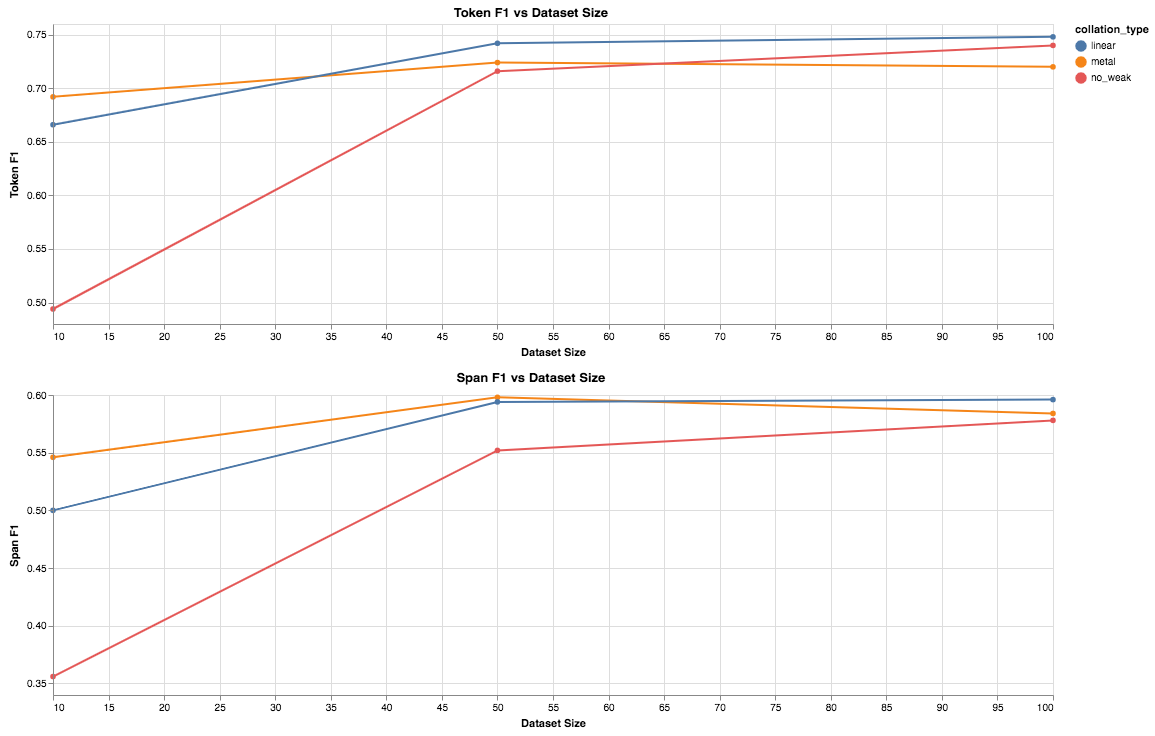

In [115]:
def metric_graph(data_frame: pd.DataFrame, metric: str, train_method: str, weak_weight: float) -> alt.Chart:
    def filter_graph(chart: alt.Chart) -> alt.Chart:
        return chart.transform_filter(
            alt.datum.metric_name == metric
        ).transform_filter(
            alt.datum.weak_train_method == train_method,
        ).transform_filter(
            alt.datum.weak_weight == weak_weight,
        )
#     .transform_filter(
#             alt.datum.collation_type != 'intersection'
#         ).transform_filter(
#             alt.datum.collation_type != 'union'
#         )

    base = alt.Chart(data_frame, title=f'{metric} vs Dataset Size')
    line = filter_graph(base.mark_line(point=True).encode(
        x=alt.X('step', title='Dataset Size'),
        y=alt.Y('mean(metric_val)', title=metric, scale=alt.Scale(zero=False)),
        color='collation_type:N',
    ))
    
    confidence_interval = filter_graph(base.mark_area(opacity=0.3).encode(
        x=alt.X('step'),
        y=alt.Y('ci0(metric_val):Q'),
        y2='ci1(metric_val):Q',
        color='collation_type:N',
    ))

    return (line).properties(width=1000)

weight = 0.01
method = 'fine_tune'
metric_graph(data_frame, 'Token F1', method, weight) & metric_graph(data_frame, 'Span F1', method, weight)